# Practice 02: Dealing with texts using CNN

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/logos/front_page.png" width=400px>

Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). _Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

## About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# Do this only once
!wget "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz" -O Train_rev1.csv.tar.gz -nc
!tar -xvzf ./Train_rev1.csv.tar.gz

File ‘Train_rev1.csv.tar.gz’ already there; not retrieving.
Train_rev1.csv


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

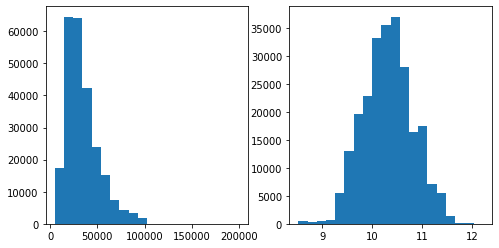

In [4]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna(
    "NaN"
)  # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
135707,70293133,Branded Restaurant Store Manager Southampton...,Branded Restaurant Store Manager Southampton...,"Southampton, Hampshire, UK, Hampshire",UK,NaN,NaN,Blue Arrow Southampton,Hospitality & Catering Jobs,18000 to 20000 per annum,19000,jobs.catererandhotelkeeper.com,9.852247
215334,72242077,Electrical Maintenance Engineer,Multi Skilled Maintenance Engineer / Shift Tec...,Southampton Hampshire South East,UK,NaN,permanent,Jenrick Engineering,Retail Jobs,28000 - 30000 per annum,29000,totaljobs.com,10.275085
207177,72127521,Web Developer JavaScript JQuery CSS HTML,Web Developer UI Developer JavaScript JQuer...,Cambridge Cambridgeshire East Anglia,UK,NaN,permanent,Ashdown IT,IT Jobs,30000 per annum + 25 days holiday & pension,30000,cwjobs.co.uk,10.308986


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk


tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
def normalize(text):
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    return " ".join(tokens)
    # <YOUR CODE HERE>


data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter

from tqdm import tqdm as tqdm


token_counts = Counter()  # <YOUR CODE HERE>

# hint: you may or may not want to use collections.Counter

In [10]:
%%time
for row in data[text_columns].values.flatten():
    token_counts.update(row.split(" "))

CPU times: user 10.5 s, sys: 27.6 ms, total: 10.5 s
Wall time: 10.8 s


In [11]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


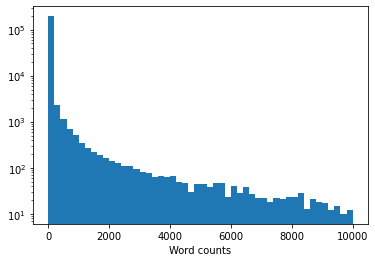

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]  # <YOUR CODE HERE>

In [14]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
# You have already done that ;)

token_to_id = {token: idx for idx, token in enumerate(tokens)}  # <YOUR CODE HERE>

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix

In [18]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer


# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

### Once again about embeddings

In [20]:
import torch
from torch import nn
from torch.nn import functional as F

In [21]:
example_matrix = torch.LongTensor(as_matrix(data["Title"][::100000]))

In [22]:
example_matrix

tensor([[10807, 30161,  2166,     1,     1],
        [15020,  2844,     1,     1,     1],
        [27645, 10201,    16, 15215, 10804]])

In [23]:
embedding_layer = nn.Embedding(len(tokens), 32)

In [24]:
embedded_example = embedding_layer(example_matrix)

In [25]:
embedded_example.shape

torch.Size([3, 5, 32])

In [26]:
name, weight_matrix = list(embedding_layer.named_parameters())[0]

In [27]:
weight_matrix.shape

torch.Size([34158, 32])

In [28]:
weight_matrix[10807]

tensor([ 0.4973, -1.7446,  0.2474, -0.5705, -0.0873, -1.2478, -0.1802, -0.6727,
         0.5944, -0.0341, -1.4297,  0.7482, -0.8169,  0.4669,  0.9090, -1.0510,
         0.5086,  0.2254, -0.6098, -2.2971, -0.5414, -1.3610,  0.8591, -0.2906,
         0.9794, -0.3182,  0.0052, -0.1461, -1.9685,  1.8827,  0.7418,  0.6642],
       grad_fn=<SelectBackward>)

In [29]:
torch.allclose(embedded_example[0, 0], weight_matrix[10807])

True

In [30]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [31]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(
    matrix,
    keep_prop,
    replace_with=UNK_IX,
    pad_ix=PAD_IX,
):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [32]:
a = make_batch(data_train[:3], max_len=10)

### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [33]:
import torch
import torch.nn.functional as F
from torch import nn

In [34]:
# You will need these to make it simple


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [35]:
reorder = Reorder()

In [36]:
embedded_example.shape

torch.Size([3, 5, 32])

In [37]:
reorder(embedded_example).shape

torch.Size([3, 32, 5])

To generate minibatches we will use simple pyton generator.

In [38]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [39]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [40]:
# Here is some startup code:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64

In [41]:
simple_model = nn.Sequential()

simple_model.add_module("emb", nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))

simple_model.add_module("reorder", Reorder())

simple_model.add_module(
    "conv1", nn.Conv1d(in_channels=hid_size, out_channels=hid_size * 2, kernel_size=3)
)

simple_model.add_module("relu1", nn.ReLU())

simple_model.add_module(
    "conv2", nn.Conv1d(in_channels=hid_size * 2, out_channels=hid_size * 2, kernel_size=3)
)


simple_model.add_module("relu2", nn.ReLU())

simple_model.add_module("bn1", nn.BatchNorm1d(num_features=hid_size * 2))


simple_model.add_module(
    "conv3", nn.Conv1d(in_channels=hid_size * 2, out_channels=hid_size * 2, kernel_size=2)
)

simple_model.add_module("relu3", nn.ReLU())


simple_model.add_module("adaptive_pool", nn.AdaptiveMaxPool1d(1))

simple_model.add_module("flatten", nn.Flatten())

simple_model.add_module("out", nn.Linear(2 * hid_size, 1))


# <YOUR CODE HERE>

__Remember!__ We are working with regression problem and predicting only one number.

In [42]:
batch["FullDescription"].shape

(3, 275)

In [43]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long)).shape

torch.Size([3, 1])

In [44]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [45]:
device

device(type='cuda')

In [46]:
simple_model.to(device)

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (relu3): ReLU()
  (adaptive_pool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

And now simple training pipeline:

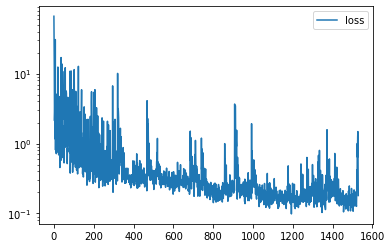

In [47]:
from random import sample

from IPython.display import clear_output


epochs = 1

model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()  # <YOUR CODE HERE>

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train, batch_size=128)):
        opt.zero_grad()

        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)

        predictions = model(batch)
        predictions = predictions.reshape(predictions.size(0))

        loss = loss_func(predictions, target)  # <YOUR CODE HERE>

        # train with backprop
        # <YOUR CODE HERE>
        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.yscale('log')
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

Let's check the model quality.

In [48]:
batch_size = 256

In [49]:
from tqdm import tqdm, tqdm_notebook


def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = squared_error_exp = abs_error_exp = num_samples = 0.0
    for batch_x, batch_y in tqdm(
        iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)
    ):
        batch = torch.tensor(batch_x["FullDescription"], dtype=torch.long).to(device)
        batch_pred = model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        squared_error_exp += np.sum(np.square(np.exp(batch_pred) - np.exp(batch_y)))
        abs_error_exp += np.sum(np.abs(np.exp(batch_pred) - np.exp(batch_y)))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    print("Mean square error exp: %.5f" % (squared_error_exp / num_samples))
    print("Mean absolute error exp: %.5f" % (abs_error_exp / num_samples))
    #return squared_error / num_samples, abs_error / num_samples


print_metrics(simple_model, data_train, name="Train")
print_metrics(simple_model, data_val, name="Val");

765it [01:27,  8.77it/s]
1it [00:00,  6.92it/s]

Train results:
Mean square error: 0.31894
Mean absolute error: 0.45635
Mean square error exp: 417962448.83557
Mean absolute error exp: 16473.57295


192it [00:22,  8.61it/s]

Val results:
Mean square error: 0.35881
Mean absolute error: 0.48788
Mean square error exp: 506562532.97447
Mean absolute error exp: 18099.94883


# Bonus area

In [50]:
from sklearn.metrics import mean_absolute_error
round(mean_absolute_error(data_train["SalaryNormalized"], [np.mean(data_train["SalaryNormalized"])]*len(data_train)))

13402

## Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [51]:
class ThreeInputsNet(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super(ThreeInputsNet, self).__init__()
        
        self.title_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        self.title_conv =  nn.Conv1d(in_channels=hid_size, out_channels=hid_size * 2, kernel_size=3)
        self.title_relu = nn.ReLU()
        self.title_pool = nn.AdaptiveMaxPool1d(1)
        self.title_flatten = nn.Flatten()
        
        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        self.full_conv =  nn.Conv1d(in_channels=hid_size, out_channels=hid_size * 2, kernel_size=3)
        self.full_relu = nn.ReLU()
        self.full_pool = nn.AdaptiveMaxPool1d(1)
        self.full_flatten = nn.Flatten()
        
        self.cat_linear = nn.Linear(in_features=n_cat_features, out_features=hid_size * 2)
        self.cat_relu = nn.ReLU()
        
        self.linear = nn.Linear(in_features=3 * hid_size * 2, out_features=1)
        

    def forward(self, whole_input):
        
        input1, input2, input3 = whole_input
        
        title = self.title_emb(input1).permute((0, 2, 1))
        title = self.title_conv(title)
        title = self.title_relu(title)
        title = self.title_pool(title)
        title = self.title_flatten(title)
        
        full = self.full_emb(input2).permute((0, 2, 1))
        full = self.full_conv(full)
        full = self.full_relu(full)
        full = self.full_pool(full)
        full = self.full_flatten(full)
        
        category = self.cat_linear(input3)
        category = self.cat_relu(category)
        
        concatenated = torch.cat([title, full, category], dim=1)
        
        out = self.linear(concatenated)
        
        return out

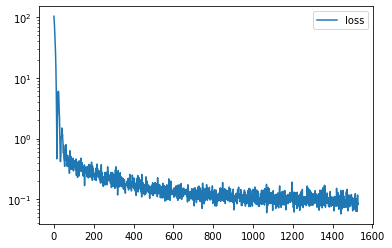

In [52]:
from random import sample

from IPython.display import clear_output


epochs = 1

model = ThreeInputsNet().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train, batch_size=128)):
        opt.zero_grad()

        whole_input = [torch.tensor(batch[key]).to(device) for key in ['Title', 'FullDescription', 'Categorical']]
        target = torch.tensor(target).to(device)

        predictions = model(whole_input)
        predictions = predictions.reshape(predictions.size(0))

        loss = loss_func(predictions, target)

        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.yscale('log')
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [53]:
batch_size = 256
from tqdm import tqdm, tqdm_notebook


def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = squared_error_exp = abs_error_exp = num_samples = 0.0
    for batch_x, batch_y in tqdm(
        iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)
    ):
        whole_input = [torch.tensor(batch_x[key]).to(device) for key in ['Title', 'FullDescription', 'Categorical']]
        batch_pred = model(whole_input)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        squared_error_exp += np.sum(np.square(np.exp(batch_pred) - np.exp(batch_y)))
        abs_error_exp += np.sum(np.abs(np.exp(batch_pred) - np.exp(batch_y)))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    print("Mean square error exp: %.5f" % (squared_error_exp / num_samples))
    print("Mean absolute error exp: %.5f" % (abs_error_exp / num_samples))
    #return squared_error / num_samples, abs_error / num_samples


print_metrics(model, data_train, name="Train")
print_metrics(model, data_val, name="Val");

765it [00:55, 13.76it/s]
2it [00:00, 12.53it/s]

Train results:
Mean square error: 0.08379
Mean absolute error: 0.21898
Mean square error exp: 124931869.49150
Mean absolute error exp: 7600.53582


192it [00:14, 13.35it/s]

Val results:
Mean square error: 0.09023
Mean absolute error: 0.22809
Mean square error exp: 135887061.73600
Mean absolute error exp: 7930.28473


## Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [54]:
class LSTM(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64,
                 lstm_hid_size=96):
        super().__init__()
        self.lstm_hid_size = lstm_hid_size
        
        self.title_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        self.title_lstm = nn.LSTM(input_size=hid_size, hidden_size=lstm_hid_size,
                                  num_layers=1, batch_first=True)
        
        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        self.full_lstm = nn.LSTM(input_size=hid_size, hidden_size=lstm_hid_size,
                                  num_layers=1, batch_first=True)
        
        self.cat_linear = nn.Linear(in_features=n_cat_features, out_features=lstm_hid_size)
        self.cat_relu = nn.ReLU()
        
        self.linear = nn.Linear(in_features=3 * lstm_hid_size, out_features=1)
        

    def forward(self, whole_input):
        
        input1, input2, input3 = whole_input
        
        title = self.title_emb(input1)
        title_output, (title_hn, title_cn) = self.title_lstm(title)
        
        full = self.full_emb(input2)
        full_output, (full_hn, full_cn) = self.full_lstm(full)
        
        category = self.cat_linear(input3)
        category = self.cat_relu(category)
        
        concatenated = torch.cat([
            title_hn.view(-1, self.lstm_hid_size),
            full_hn.view(-1, self.lstm_hid_size),
            category], dim=1)
        
        out = self.linear(concatenated)
        
        return out

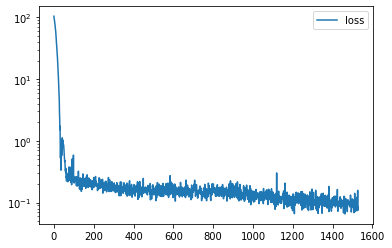

In [55]:
from random import sample

from IPython.display import clear_output


epochs = 1

model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train, batch_size=128)):
        opt.zero_grad()

        whole_input = [torch.tensor(batch[key]).to(device) for key in ['Title', 'FullDescription', 'Categorical']]
        target = torch.tensor(target).to(device)

        predictions = model(whole_input)
        predictions = predictions.reshape(predictions.size(0))

        loss = loss_func(predictions, target)

        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.yscale('log')
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [56]:
print_metrics(model, data_train, name="Train")
print_metrics(model, data_val, name="Val");

765it [01:08, 11.16it/s]
1it [00:00,  9.87it/s]

Train results:
Mean square error: 0.09507
Mean absolute error: 0.23158
Mean square error exp: 144871982.70424
Mean absolute error exp: 8014.59780


192it [00:17, 10.80it/s]

Val results:
Mean square error: 0.09638
Mean absolute error: 0.23424
Mean square error exp: 147816033.97802
Mean absolute error exp: 8116.23469


In [57]:
print("num of LSTM params: {}".format(sum(p.numel() for p in LSTM().parameters() if p.requires_grad == True)))

num of LSTM params: 4858753


In [58]:
print("num of ThreeInputsNet params: {}".format(sum(p.numel() for p in ThreeInputsNet().parameters() if p.requires_grad == True)))

num of ThreeInputsNet params: 4904449


## Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


### Data preparation

In [59]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [60]:
%%time

token_counts = Counter()

for row in data_train[text_columns].values.flatten():
    token_counts.update(row.split(" "))

CPU times: user 9.77 s, sys: 12.3 ms, total: 9.78 s
Wall time: 10.1 s


In [61]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 179241
('and', 2123096)
('.', 2018563)
(',', 1853938)
('the', 1663289)
('to', 1613615)
...
('pate', 1)
('nurseportadown', 1)
('salesexecutivesx2northwestlondonesp', 1)


In [62]:
min_count = 10

tokens = [token for token, count in token_counts.items() if count >= min_count]

In [63]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 30715


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [64]:
# You have already done that ;)

token_to_id = {token: idx for idx, token in enumerate(tokens)}

### ThreeInputsNet

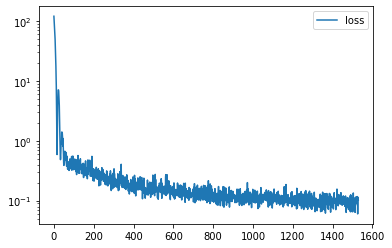

In [65]:
from random import sample

from IPython.display import clear_output


epochs = 1

model = ThreeInputsNet(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)).to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train, batch_size=128)):
        opt.zero_grad()

        whole_input = [torch.tensor(batch[key]).to(device) for key in ['Title', 'FullDescription', 'Categorical']]
        target = torch.tensor(target).to(device)

        predictions = model(whole_input)
        predictions = predictions.reshape(predictions.size(0))

        loss = loss_func(predictions, target)

        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.yscale('log')
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [66]:
print_metrics(model, data_train, name="Train")
print_metrics(model, data_val, name="Val");

765it [00:53, 14.30it/s]
2it [00:00, 11.92it/s]

Train results:
Mean square error: 0.08492
Mean absolute error: 0.21954
Mean square error exp: 129402623.56857
Mean absolute error exp: 7632.66157


192it [00:13, 13.96it/s]

Val results:
Mean square error: 0.09083
Mean absolute error: 0.22831
Mean square error exp: 139077300.41427
Mean absolute error exp: 7935.66131


### LSTM

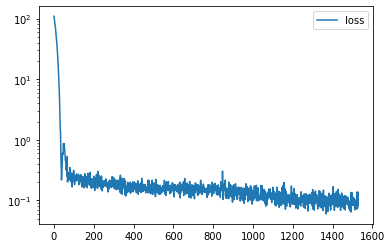

In [67]:
from random import sample

from IPython.display import clear_output


epochs = 1

model = LSTM(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)).to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train, batch_size=128)):
        opt.zero_grad()

        whole_input = [torch.tensor(batch[key]).to(device) for key in ['Title', 'FullDescription', 'Categorical']]
        target = torch.tensor(target).to(device)

        predictions = model(whole_input)
        predictions = predictions.reshape(predictions.size(0))

        loss = loss_func(predictions, target)

        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.yscale('log')
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [68]:
print_metrics(model, data_train, name="Train")
print_metrics(model, data_val, name="Val");

765it [01:08, 11.10it/s]
1it [00:00,  8.47it/s]

Train results:
Mean square error: 0.09404
Mean absolute error: 0.22832
Mean square error exp: 150809066.53310
Mean absolute error exp: 7910.51957


192it [00:20,  9.22it/s]

Val results:
Mean square error: 0.09502
Mean absolute error: 0.23067
Mean square error exp: 153207726.86064
Mean absolute error exp: 8004.09064


__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)